# Business Goal
TBD

# Data preparation

In [122]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

### Read data sets

In [83]:
# Load the data from zip file
application_df = pd.read_csv('data/application_record.zip')
credit_df = pd.read_csv('data/credit_record.zip')

### Construct target label

In [84]:
credit_df.sample(5)

,ID,MONTHS_BALANCE,STATUS
327339,5033710,-33,X
26037,5002896,-37,C
878945,5120963,-41,C
1024761,5148872,-6,X
473931,5059770,-3,C


***Content explanation***
* ID - Client number	　
* MONTHS_BALANCE - Record month	The month of the extracted data is the starting point, backwards, 0 is the current month, -1 is the previous month, and so on
* STATUS	Status	0: 1-29 days past due 1: 30-59 days past due 2: 60-89 days overdue 3: 90-119 days overdue 4: 120-149 days overdue 5: Overdue or bad debts, write-offs for more than 150 days C: paid off that month X: No loan for the month

In [85]:
# count unique ids in credit_df
cred_uids = credit_df['ID'].nunique()

# count unique ids in application_df
app_uids = application_df['ID'].nunique()

print(f'Unique IDs in credit_df: {cred_uids}')
print(f'Unique IDs in application_df: {app_uids}')

Unique IDs in credit_df: 45985
Unique IDs in application_df: 438510


Here we can see that credit records contain fewer unique IDs compared to application records. However, we need to filter credit records further.

To build a target label we will use the following strategy:
* "Bad" client - anyone who has records with 30 days overdue or more in the last two years
* "Good" client - anyone who has a credit record history for the last 2 years and no overdue over 30 days

Clients who don't match good or bad criteria will be ignored.

In [86]:
valid_credit_records = credit_df[credit_df['MONTHS_BALANCE'] >= -24]

print(f'Clients with a valid credit history: {valid_credit_records["ID"].nunique()}')

Clients with a valid credit history: 42596


In [87]:
# select all applications records that has id in valid_credit_records
valid_applications = application_df[application_df['ID'].isin(valid_credit_records['ID'])]

In [88]:
print(f'Amount of valid applications: {valid_applications["ID"].nunique()}')

Amount of valid applications: 33068


In [89]:
# add a column to valid_applications that indicates if the client is good or bad
valid_applications['STATUS'] = 1 # good
valid_applications.loc[valid_applications['ID'].isin(credit_df[credit_df['STATUS'].isin(['1','2','3','4', '5'])]['ID']), 'STATUS'] = 0 # bad

/var/folders/rz/d543tms9543f_v11vps9f2s00000gp/T/ipykernel_95348/333513147.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_applications['STATUS'] = 1 # good


In [90]:
valid_applications.shape

(33068, 19)

As a result of target label construction, we have about 33k records and 18 features in our data set.

# Data Analysis

In [91]:
# inspect the data
valid_applications.head(5)

,ID,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,STATUS
0,5008804,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0,0
1,5008805,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0,0
2,5008806,M,Y,Y,0,112500.0,Working,Secondary / secondary special,Married,House / apartment,-21474,-1134,1,0,0,0,Security staff,2.0,1
3,5008808,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.0,1
4,5008809,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.0,1


In [92]:
valid_applications.info()

<class 'pandas.core.frame.DataFrame'>
Index: 33068 entries, 0 to 434812
Data columns (total 19 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   ID                   33068 non-null  int64  
 1   CODE_GENDER          33068 non-null  object 
 2   FLAG_OWN_CAR         33068 non-null  object 
 3   FLAG_OWN_REALTY      33068 non-null  object 
 4   CNT_CHILDREN         33068 non-null  int64  
 5   AMT_INCOME_TOTAL     33068 non-null  float64
 6   NAME_INCOME_TYPE     33068 non-null  object 
 7   NAME_EDUCATION_TYPE  33068 non-null  object 
 8   NAME_FAMILY_STATUS   33068 non-null  object 
 9   NAME_HOUSING_TYPE    33068 non-null  object 
 10  DAYS_BIRTH           33068 non-null  int64  
 11  DAYS_EMPLOYED        33068 non-null  int64  
 12  FLAG_MOBIL           33068 non-null  int64  
 13  FLAG_WORK_PHONE      33068 non-null  int64  
 14  FLAG_PHONE           33068 non-null  int64  
 15  FLAG_EMAIL           33068 non-null  int

#### Content explanation

| Feature name        | Explanation              | Remarks                                                                                     |
|---------------------|--------------------------|---------------------------------------------------------------------------------------------|
| ID                  | Client number            |                                                                                             |
| CODE_GENDER         | Gender                   |                                                                                             |
| FLAG_OWN_CAR        | Is there a car           |                                                                                             |
| FLAG_OWN_REALTY     | Is there a property      |                                                                                             |
| CNT_CHILDREN        | Number of children       |                                                                                             |
| AMT_INCOME_TOTAL    | Annual income            |                                                                                             |
| NAME_INCOME_TYPE    | Income category          |                                                                                             |
| NAME_EDUCATION_TYPE | Education level          |                                                                                             |
| NAME_FAMILY_STATUS  | Marital status           |                                                                                             |
| NAME_HOUSING_TYPE   | Way of living            |                                                                                             |
| DAYS_BIRTH          | Birthday                 | Count backwards from current day (0), -1 means yesterday                                    |
| DAYS_EMPLOYED       | Start date of employment | Count backwards from current day(0). If positive, it means the person currently unemployed. |
| FLAG_MOBIL          | Is there a mobile phone  |                                                                                             |
| FLAG_WORK_PHONE     | Is there a work phone    |                                                                                             |
| FLAG_PHONE          | Is there a phone         |                                                                                             |
| FLAG_EMAIL          | Is there an email        |                                                                                             |
| OCCUPATION_TYPE     | Occupation               |                                                                                             |
| CNT_FAM_MEMBERS     | Family size              |                                                                                             |

In [93]:
# Check for missing values
valid_applications.isnull().sum()

ID                         0
CODE_GENDER                0
FLAG_OWN_CAR               0
FLAG_OWN_REALTY            0
CNT_CHILDREN               0
AMT_INCOME_TOTAL           0
NAME_INCOME_TYPE           0
NAME_EDUCATION_TYPE        0
NAME_FAMILY_STATUS         0
NAME_HOUSING_TYPE          0
DAYS_BIRTH                 0
DAYS_EMPLOYED              0
FLAG_MOBIL                 0
FLAG_WORK_PHONE            0
FLAG_PHONE                 0
FLAG_EMAIL                 0
OCCUPATION_TYPE        10197
CNT_FAM_MEMBERS            0
STATUS                     0
dtype: int64

In [94]:
# Get percentage of missing values for OCCUPATION_TYPE
mp = valid_applications['OCCUPATION_TYPE'].isnull().mean()
print(f'Percentage of missing values in OCCUPATION_TYPE: {mp:.2%}')

Percentage of missing values in OCCUPATION_TYPE: 30.84%


In [95]:
# Check value counts for OCCUPATION_TYPE column
valid_applications['OCCUPATION_TYPE'].value_counts()

OCCUPATION_TYPE
Laborers                 5689
Core staff               3267
Sales staff              3173
Managers                 2734
Drivers                  1953
High skill tech staff    1264
Accountants              1119
Medicine staff           1083
Cooking staff             587
Security staff            534
Cleaning staff            508
Private service staff     310
Low-skill Laborers        157
Waiters/barmen staff      153
Secretaries               141
HR staff                   75
Realty agents              67
IT staff                   57
Name: count, dtype: int64

In [96]:
# Check correlation between NAME_INCOME_TYPE and OCCUPATION_TYPE and see if it helps to fill the missing values
valid_applications.groupby('NAME_INCOME_TYPE')['OCCUPATION_TYPE'].value_counts().unstack()

OCCUPATION_TYPE,Accountants,Cleaning staff,Cooking staff,Core staff,Drivers,HR staff,High skill tech staff,IT staff,Laborers,Low-skill Laborers,Managers,Medicine staff,Private service staff,Realty agents,Sales staff,Secretaries,Security staff,Waiters/barmen staff
NAME_INCOME_TYPE,,,,,,,,,,,,,,,,,,
Commercial associate,438.0,100.0,109.0,737.0,508.0,24.0,373.0,20.0,1354.0,39.0,1073.0,157.0,134.0,48.0,1088.0,25.0,172.0,45.0
Pensioner,1.0,NaN,NaN,5.0,1.0,NaN,NaN,NaN,3.0,1.0,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN
State servant,85.0,17.0,52.0,825.0,110.0,3.0,173.0,10.0,177.0,3.0,270.0,347.0,19.0,NaN,10.0,32.0,21.0,35.0
Student,NaN,NaN,NaN,8.0,NaN,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Working,595.0,391.0,426.0,1692.0,1334.0,48.0,718.0,27.0,4153.0,114.0,1390.0,578.0,157.0,19.0,2075.0,84.0,341.0,73.0


In [97]:
# Group by NAME_INCOME_TYPE and get the most frequent OCCUPATION_TYPE
occupation_map = valid_applications.groupby('NAME_INCOME_TYPE')['OCCUPATION_TYPE'].agg(lambda x: x.mode().iloc[0])
occupation_map

NAME_INCOME_TYPE
Commercial associate      Laborers
Pensioner               Core staff
State servant           Core staff
Student                 Core staff
Working                   Laborers
Name: OCCUPATION_TYPE, dtype: object

In [98]:
# fill missing values in OCCUPATION_TYPE based on occupation_map
valid_applications['OCCUPATION_TYPE'] = valid_applications['OCCUPATION_TYPE'].fillna(valid_applications['NAME_INCOME_TYPE'].map(occupation_map))
valid_applications['OCCUPATION_TYPE'].value_counts()

/var/folders/rz/d543tms9543f_v11vps9f2s00000gp/T/ipykernel_95348/574121484.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_applications['OCCUPATION_TYPE'] = valid_applications['OCCUPATION_TYPE'].fillna(valid_applications['NAME_INCOME_TYPE'].map(occupation_map))


OCCUPATION_TYPE
Laborers                 9850
Core staff               9303
Sales staff              3173
Managers                 2734
Drivers                  1953
High skill tech staff    1264
Accountants              1119
Medicine staff           1083
Cooking staff             587
Security staff            534
Cleaning staff            508
Private service staff     310
Low-skill Laborers        157
Waiters/barmen staff      153
Secretaries               141
HR staff                   75
Realty agents              67
IT staff                   57
Name: count, dtype: int64

In [99]:
# Summary statistics for numerical features
valid_applications.describe()

,ID,CNT_CHILDREN,AMT_INCOME_TOTAL,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,CNT_FAM_MEMBERS,STATUS
count,3.306800e+04,33068.000000,3.306800e+04,33068.000000,33068.000000,33068.0,33068.000000,33068.000000,33068.000000,33068.000000,33068.000000
mean,5.078528e+06,0.429902,1.868803e+05,-15952.568465,58945.466100,1.0,0.227319,0.295754,0.091266,2.198530,0.878704
std,4.186223e+04,0.744746,1.020080e+05,4205.608477,137352.055153,0.0,0.419107,0.456388,0.287992,0.913398,0.326475
min,5.008804e+06,0.000000,2.700000e+04,-25152.000000,-15713.000000,1.0,0.000000,0.000000,0.000000,1.000000,0.000000
25%,5.042241e+06,0.000000,1.215000e+05,-19431.000000,-3143.000000,1.0,0.000000,0.000000,0.000000,2.000000,1.000000
50%,5.074674e+06,0.000000,1.575000e+05,-15527.000000,-1539.000000,1.0,0.000000,0.000000,0.000000,2.000000,1.000000
75%,5.115465e+06,1.000000,2.250000e+05,-12442.000000,-407.000000,1.0,0.000000,1.000000,0.000000,3.000000,1.000000
max,5.150487e+06,19.000000,1.575000e+06,-7489.000000,365243.000000,1.0,1.000000,1.000000,1.000000,20.000000,1.000000


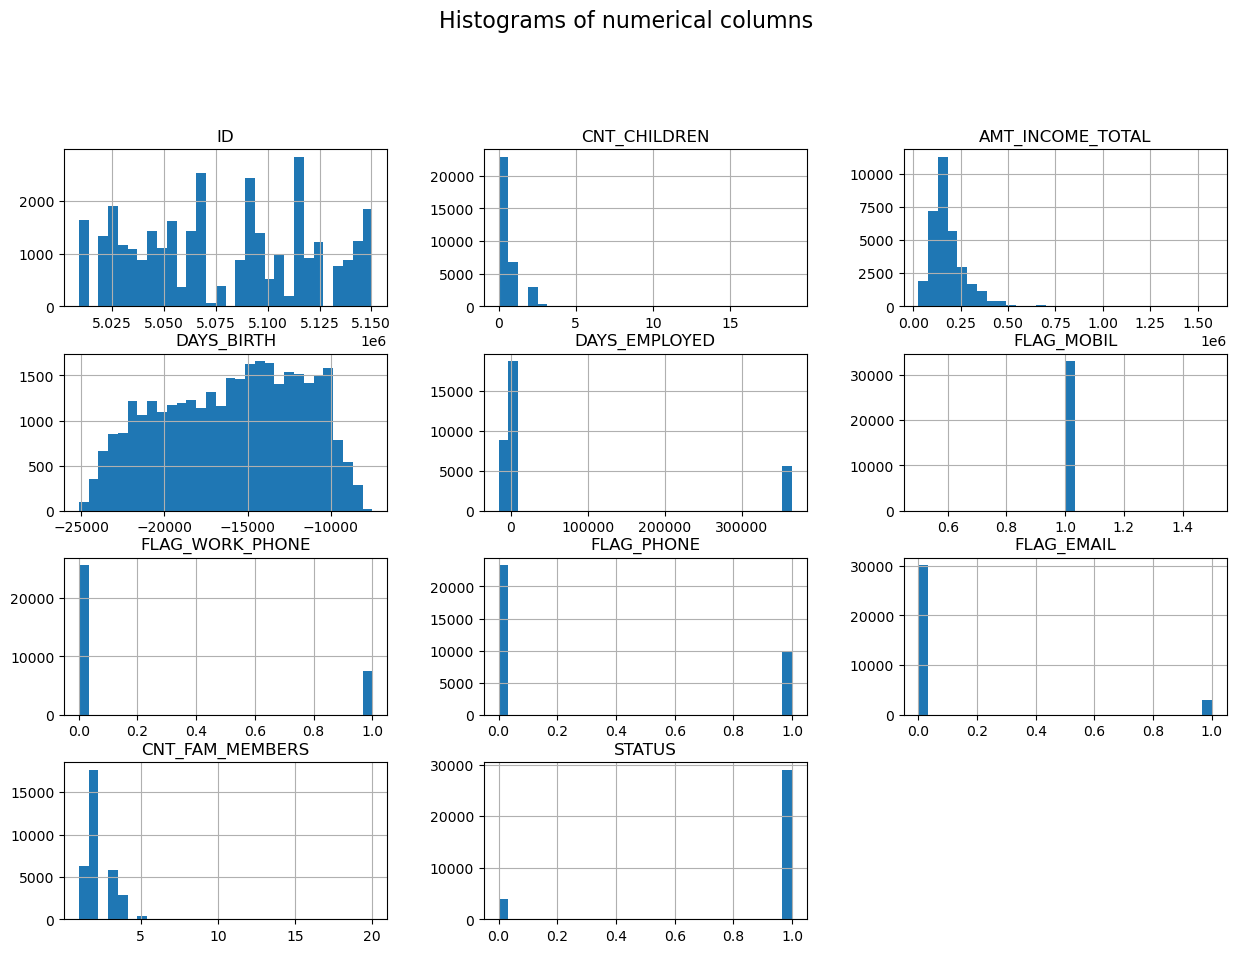

In [105]:
valid_applications.hist(bins=30, figsize=(15, 10))
plt.suptitle('Histograms of numerical columns', y=1.02, size=16)
plt.show()

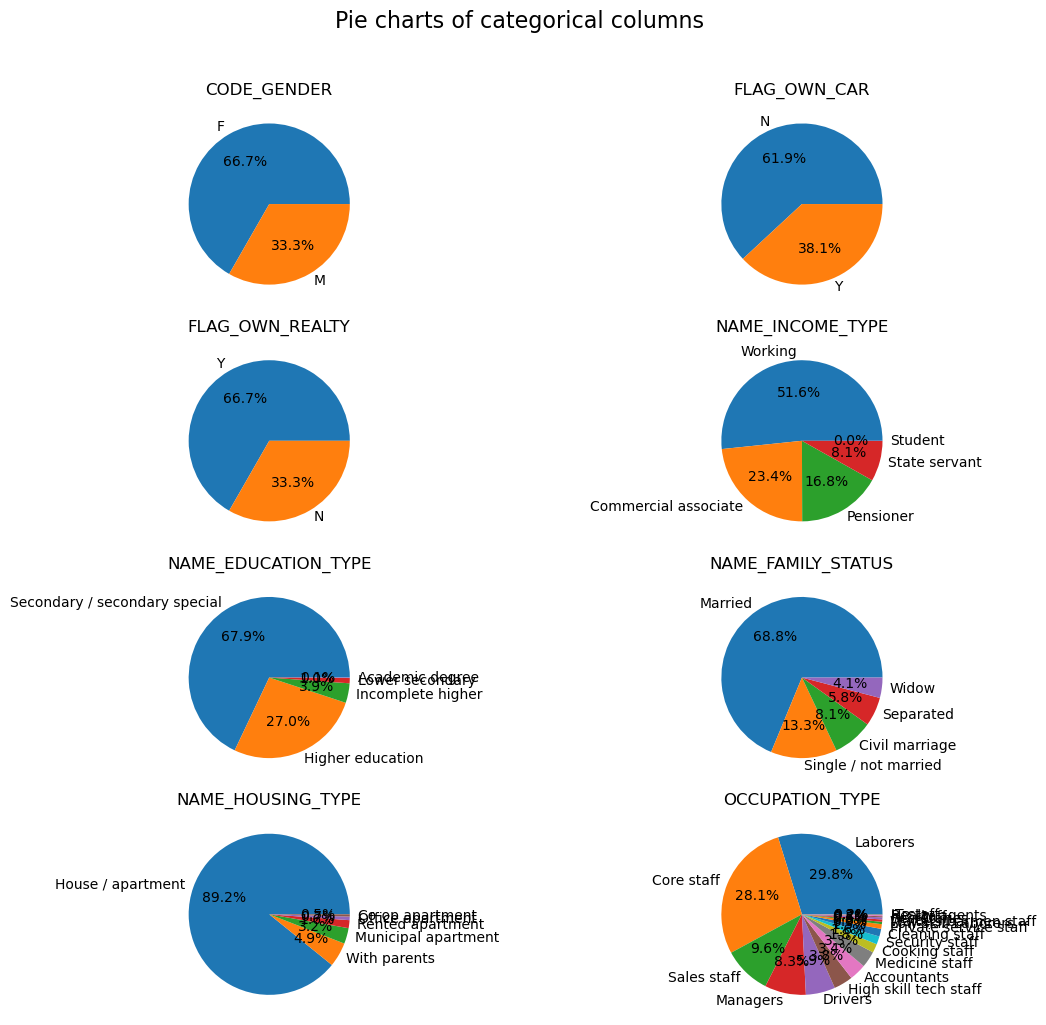

In [115]:
# plot pie chart for categorical features
fig, axes = plt.subplots(4, 2, figsize=(12, 10))
for i, col in enumerate(valid_applications.select_dtypes(include='object').columns):
    valid_applications[col].value_counts().plot.pie(autopct='%1.1f%%', ax=axes[i//2, i%2])
    axes[i//2, i%2].set_ylabel('')
    axes[i//2, i%2].set_title(col)
    
plt.suptitle('Pie charts of categorical columns', y=1.02, size=16)
plt.tight_layout()

In [113]:
# Based on the histograms and pie charts, we can see that there are some columns like FLAG_MOBIL that has only one value, so we can drop them. Or ID column that is not useful for our analysis.
# As the first step, we will drop these columns: FLAG_MOBIL, FLAG_EMAIL, FLAG_PHONE, FLAG_WORK_PHONE, ID
df = valid_applications.drop(columns=['FLAG_MOBIL', 'FLAG_EMAIL', 'FLAG_PHONE', 'FLAG_WORK_PHONE', 'ID'])

In [117]:
# remove outliers in CNT_CHILDREN column
df = df[df['CNT_CHILDREN'] < 6]
df['CNT_CHILDREN'].value_counts()

CNT_CHILDREN
0    22892
1     6754
2     2950
3      394
4       55
5       17
Name: count, dtype: int64

Text(0.5, 1.0, 'Histogram of AMT_INCOME_TOTAL')

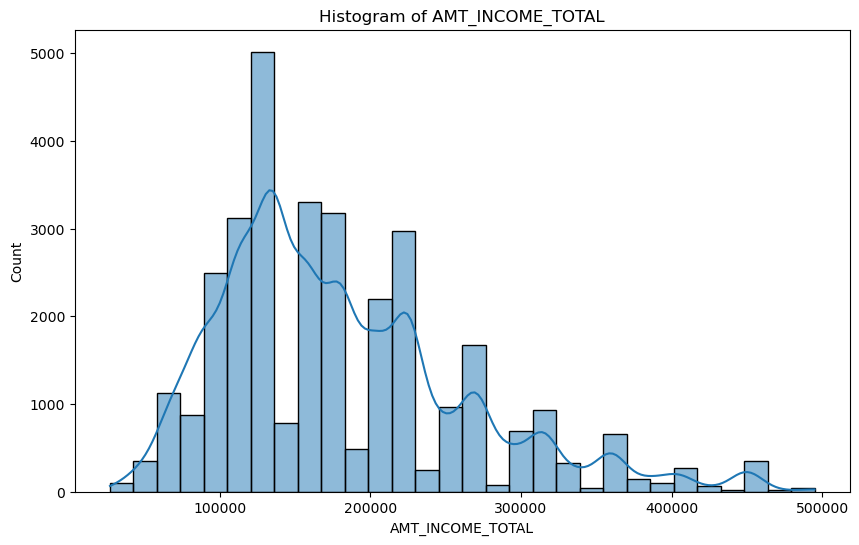

In [120]:
# remove outliers in AMT_INCOME_TOTAL column
df = df[df['AMT_INCOME_TOTAL'] < 500000]
# plot histogram for AMT_INCOME_TOTAL
plt.figure(figsize=(10, 6))
sns.histplot(df['AMT_INCOME_TOTAL'], bins=30, kde=True)
plt.title('Histogram of AMT_INCOME_TOTAL')

In [121]:
# convert DAYS_BIRTH to years
df['AGE'] = df['DAYS_BIRTH'] // -365
df = df.drop(columns='DAYS_BIRTH')

# convert DAYS_EMPLOYED to years
df['YEARS_EMPLOYED'] = df['DAYS_EMPLOYED'] // -365
# replace negative values with 0
df['YEARS_EMPLOYED'] = df['YEARS_EMPLOYED'].apply(lambda x: 0 if x < 0 else x)
df = df.drop(columns='DAYS_EMPLOYED')

# plot of AGE vs YEARS_EMPLOYED
fig = px.scatter(df, x='AGE', y='YEARS_EMPLOYED', color='STATUS', title='Scatter plot of AGE vs YEARS_EMPLOYED')
fig.show()

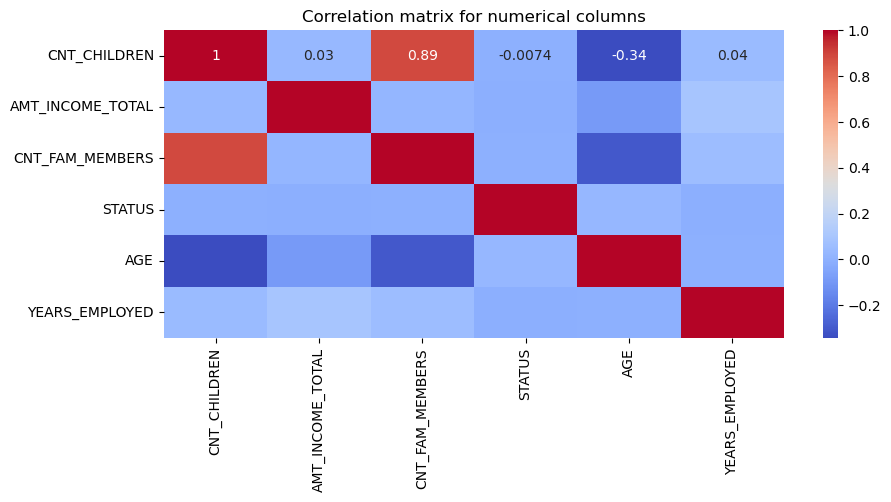

In [130]:
# plot correlation matrix for numerical values
plt.figure(figsize=(10, 4))
sns.heatmap(df.select_dtypes(exclude='object').corr(), annot=True, cmap='coolwarm')
plt.title('Correlation matrix for numerical columns')
plt.show()

Based on correlation mapping we have a high correlation between Family members and numbers of children which makes sense. 

In [150]:
# remove duplicate rows
df = df.drop_duplicates()

In [151]:
# check for duplicate rows
duplicates = df.duplicated().sum()
print(f'Number of duplicate rows: {duplicates}')

# check for missing values 
missing_values = df.isnull().sum().sum()
print(f'Number of missing values: {missing_values}')

# print the shape of the dataframe
print(f'Shape of the dataframe: {df.shape}')

Number of duplicate rows: 0
Number of missing values: 0
Shape of the dataframe: (10703, 14)


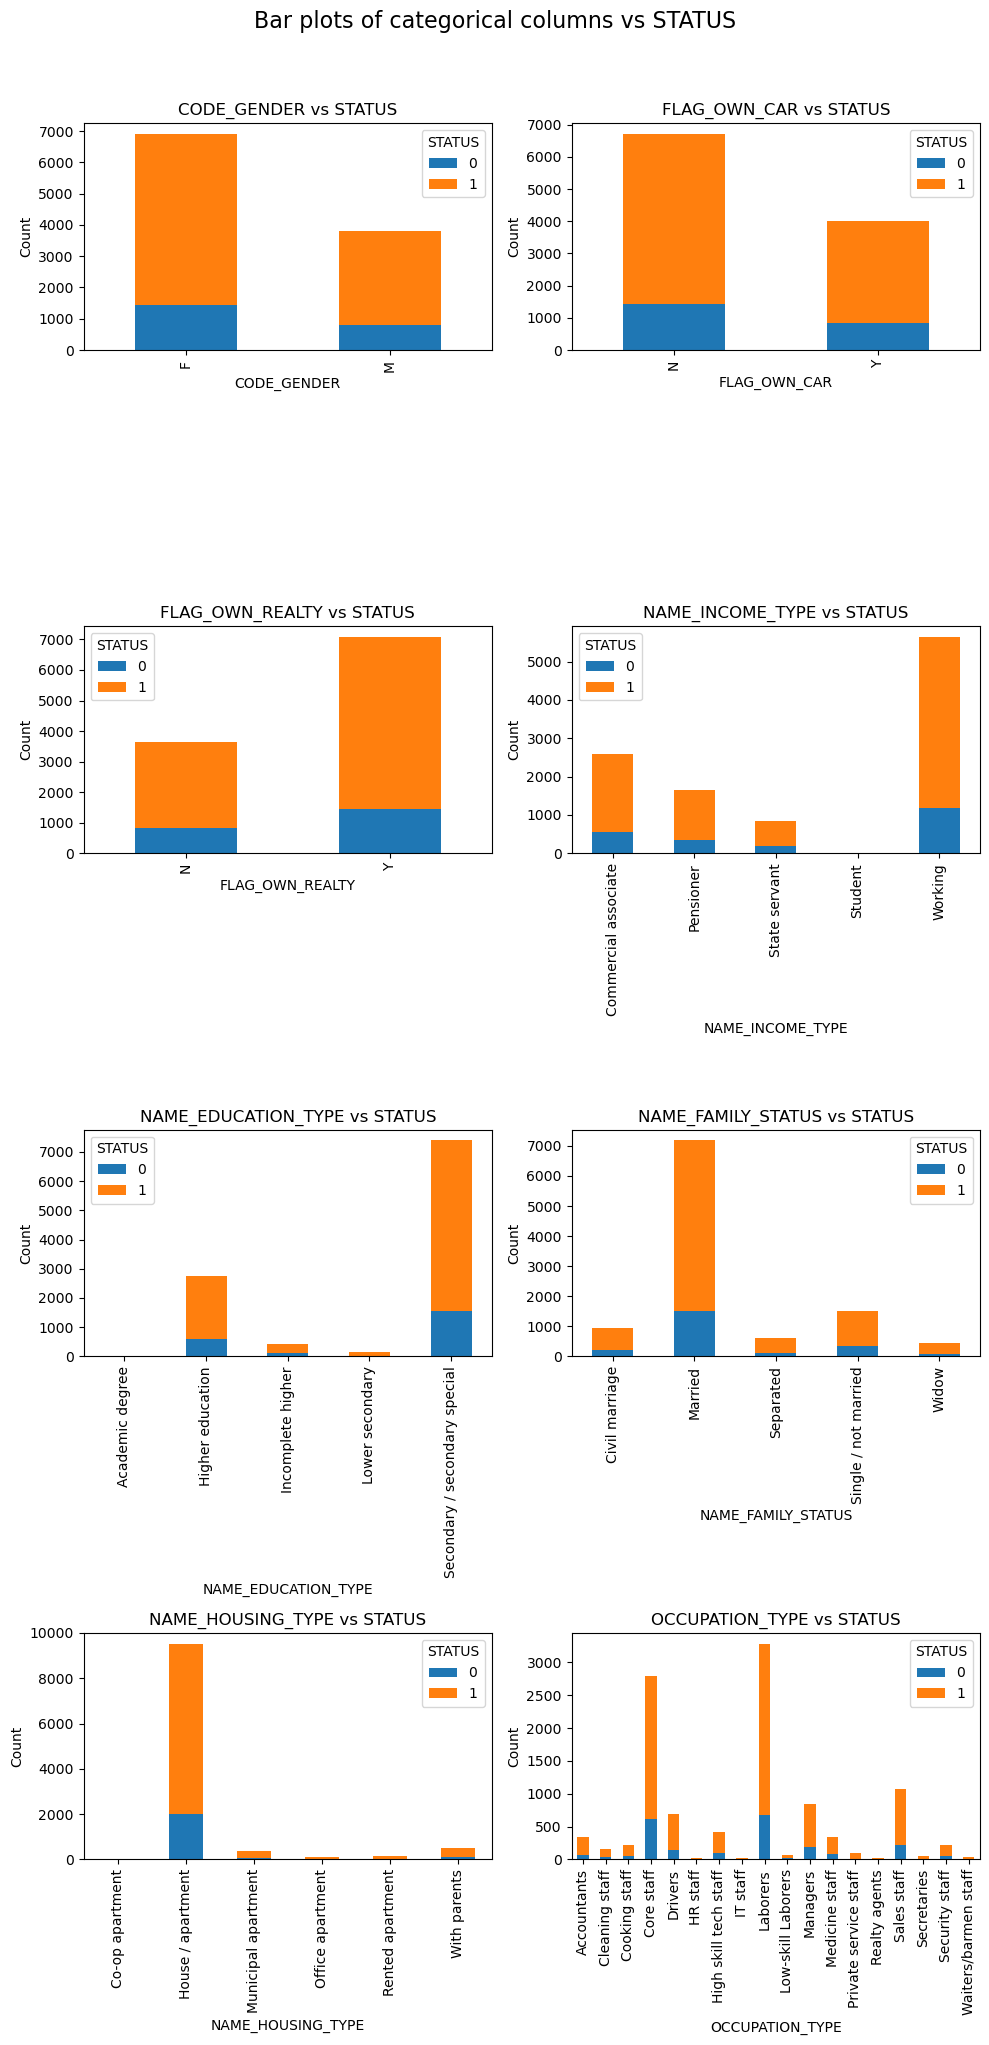

In [152]:
# do cross-tabulation for categorical columns and plot the data
fig, axes = plt.subplots(4, 2, figsize=(10, 20))
for i, col in enumerate(df.select_dtypes(include='object').columns):
    pd.crosstab(df[col], df['STATUS']).plot(kind='bar', stacked=True, ax=axes[i//2, i%2])
    axes[i//2, i%2].set_title(f'{col} vs STATUS')
    axes[i//2, i%2].set_ylabel('Count')
    axes[i//2, i%2].set_xlabel(col)

plt.suptitle('Bar plots of categorical columns vs STATUS', y=1.02, size=16)
plt.tight_layout()



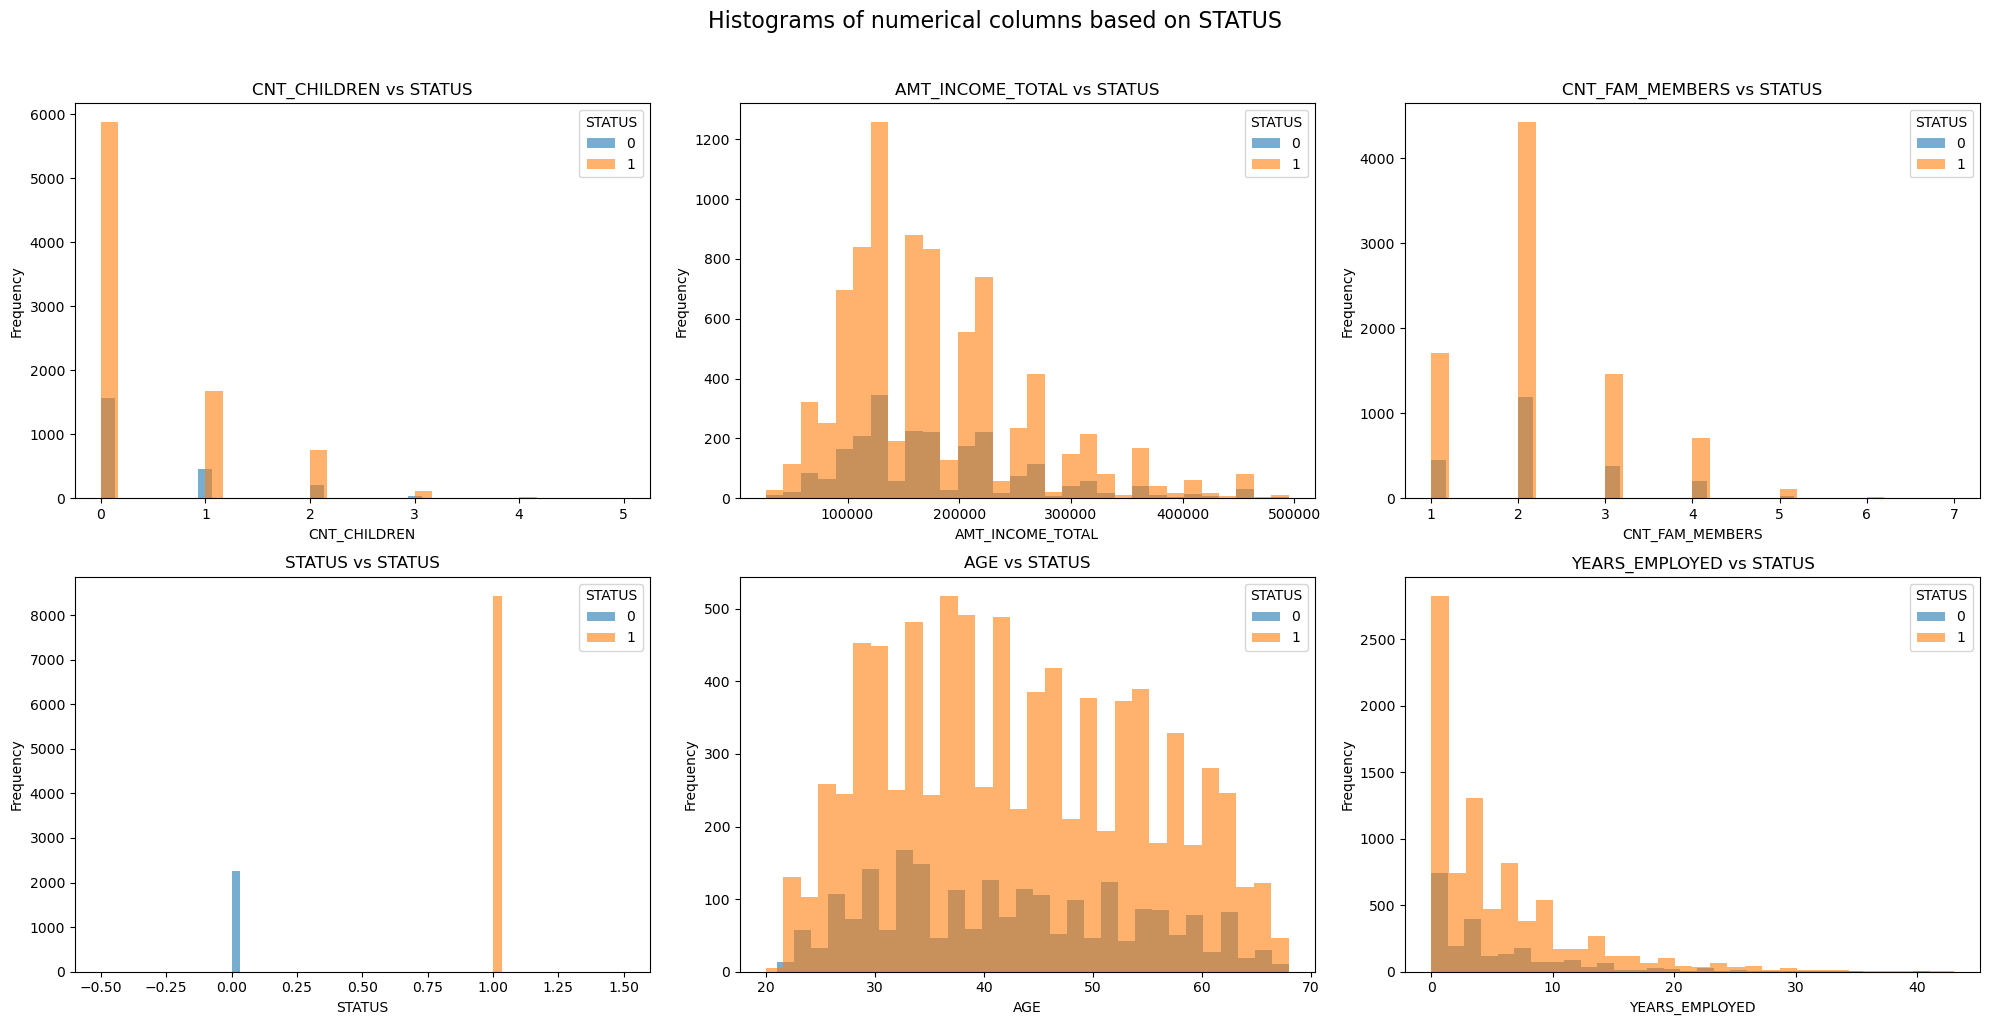

In [153]:
# plot histogram for numerical columns based on STATUS
fig, axes = plt.subplots(2, 3, figsize=(20, 10))
for i, col in enumerate(df.select_dtypes(exclude='object').columns):
    df.groupby('STATUS')[col].plot(kind='hist', bins=30, alpha=0.6, ax=axes[i//3, i%3])
    axes[i//3, i%3].set_title(f'{col} vs STATUS')
    axes[i//3, i%3].set_xlabel(col)
    axes[i//3, i%3].legend(title='STATUS')
    
plt.suptitle('Histograms of numerical columns based on STATUS', y=1.02, size=16)
plt.tight_layout()